In [1]:
import sys
import pystan
import stan_utility

import arviz as az
import numpy as np
import scipy.stats as stats
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200



In [3]:
dts=[24,734,25,516,31,754,31,877,22,814,21,362,26,764,20,809,16,223,22,1066]
c1=dts[::2]
c2=dts[1::2]

Airline_data=pd.DataFrame({'Year':[1976,1977,1978,1979,1980,1981,1982,1983,1984,1985],
'Fatal accidents':c1,  
'Passenger deaths':c2,
'Death rate':[0.19,0.12,0.15,0.16,0.14,0.06,0.13,0.13,0.03,0.15]}).set_index('Year')
Airline_data['Miles flown [100 mln miles]']=np.round(Airline_data['Passenger deaths']/Airline_data['Death rate'])

## generation of vector for plotting samples under histograms
acc=[]
dta_cnt=[]
for k in Airline_data['Fatal accidents']:  
    dta_cnt.append(-(1.+acc.count(k)))
    acc.append(k)
dta_cnt=np.array(dta_cnt)

Airline_data

,Fatal accidents,Passenger deaths,Death rate,Miles flown [100 mln miles]
Year,,,,
1976,24,734,0.19,3863.0
1977,25,516,0.12,4300.0
1978,31,754,0.15,5027.0
1979,31,877,0.16,5481.0
1980,22,814,0.14,5814.0
1981,21,362,0.06,6033.0
1982,26,764,0.13,5877.0
1983,20,809,0.13,6223.0
1984,16,223,0.03,7433.0


1. I assume that the rate ($\lambda$) is constant for all years and not depending on anything and that number of passengers deaths ($y_i$) has Poisson distribution: $$y_i\sim\mathrm{Poisson}(\lambda)$$
We assume that 5 deaths every day would be very improbable. For poisson distribution we have mean of $\lambda$ and standard deviation of $\sqrt{\lambda}$. Approximately in order to have no more than 1% probability $\lambda$ should fulfill $$\lambda+3\sqrt{\lambda}\approx5*365=1825$$ 

In [4]:
root_of_lam=np.polynomial.polynomial.polyroots([-1825.,3.,1.])
lam_ub=np.round(root_of_lam[root_of_lam>0]**2)
print(lam_ub)

[1701.]


Using Stan algebra solver i can find $\sigma$ for a HalfNormal distribution that is fulfilling the conditions we have given.

In [5]:
with open('prior_tune3.stan', 'r') as file:
    print(file.read())

functions {
  // Difference between one-sided Gaussian tail probability and target probability
  vector tail_delta(vector y, vector theta, real[] x_r, int[] x_i) {
    vector[1] deltas;
    deltas[1] = 2 * (normal_cdf(theta[1], 0, exp(y[1])) - 0.5) - 0.99;
    return deltas;
  }
}

data {
  vector[1] y_guess; // Initial guess of Gaussian standard deviation
  vector[1] theta;       // Target quantile
}

transformed data {

  vector[1] y;
  real x_r[0];
  int x_i[0];

  // Find Gaussian standard deviation that ensures 99% probabilty below 15
  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i);

  print("Standard deviation = ", exp(y[1]));
}

generated quantities {
  real sigma = exp(y[1]);
}
//source: https://github.com/KAIR-ISZ


In [6]:
tuning2=stan_utility.compile_model('prior_tune3.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_30c9bf31b72711ea6b1145c3d0c5fc8f NOW.


In [8]:
data=dict(y_guess=np.array([np.log(1000)]),theta=np.array(lam_ub))
tuned2 = tuning2.sampling(data=data,
                          seed=1052020,
                          algorithm="Fixed_param",
                          iter=1, 
                          warmup=0,
                          chains=1)
sigma = np.round(tuned2.extract()['sigma'][0])
print(sigma)

660.0


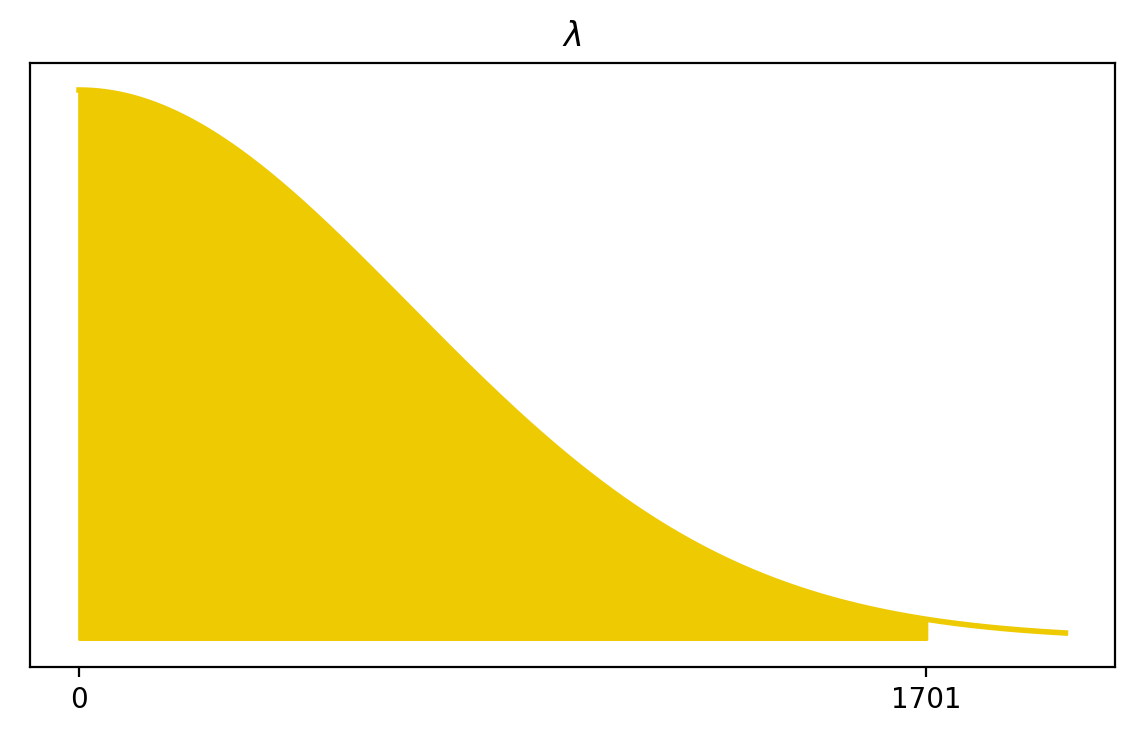

In [9]:
fig, ax2 = plt.subplots(1, 1,figsize=(7, 4))
x2=np.linspace(0,3*sigma,1000)
x4=np.linspace(0,lam_ub[0],1000)
ax2.plot(x2,2*stats.norm.pdf(x2,scale=sigma),color=dark,linewidth=2)
ax2.fill_between(x4,2*stats.norm.pdf(x4,scale=sigma),0,color=dark)
ax2.set_yticks([])
ax2.set_xticks([0,lam_ub[0]])
ax2.set_title(r'$\lambda$')
plt.show()

I will use stan to simulate possible outputs and parameteres based only on prior information.

In [10]:
with open('airline_FA_hnorm_ppc.stan', 'r') as file:
    print(file.read())

data {
  int M;
}

generated quantities {
  real lambda=fabs(normal_rng(0,1348));
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(lambda);
  }
}

//source: https://github.com/KAIR-ISZ




In [11]:
model_prior=stan_utility.compile_model('airline_FA_hnorm_ppc.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f0dfcd89010d49a473af62ef26604ccf NOW.


In [12]:
R=1000
sim_uf=model_prior.sampling(data={'M':1},
                            algorithm="Fixed_param",
                            iter=R,
                            warmup=0,
                            chains=1, 
                            refresh=R,
                            seed=29042020)

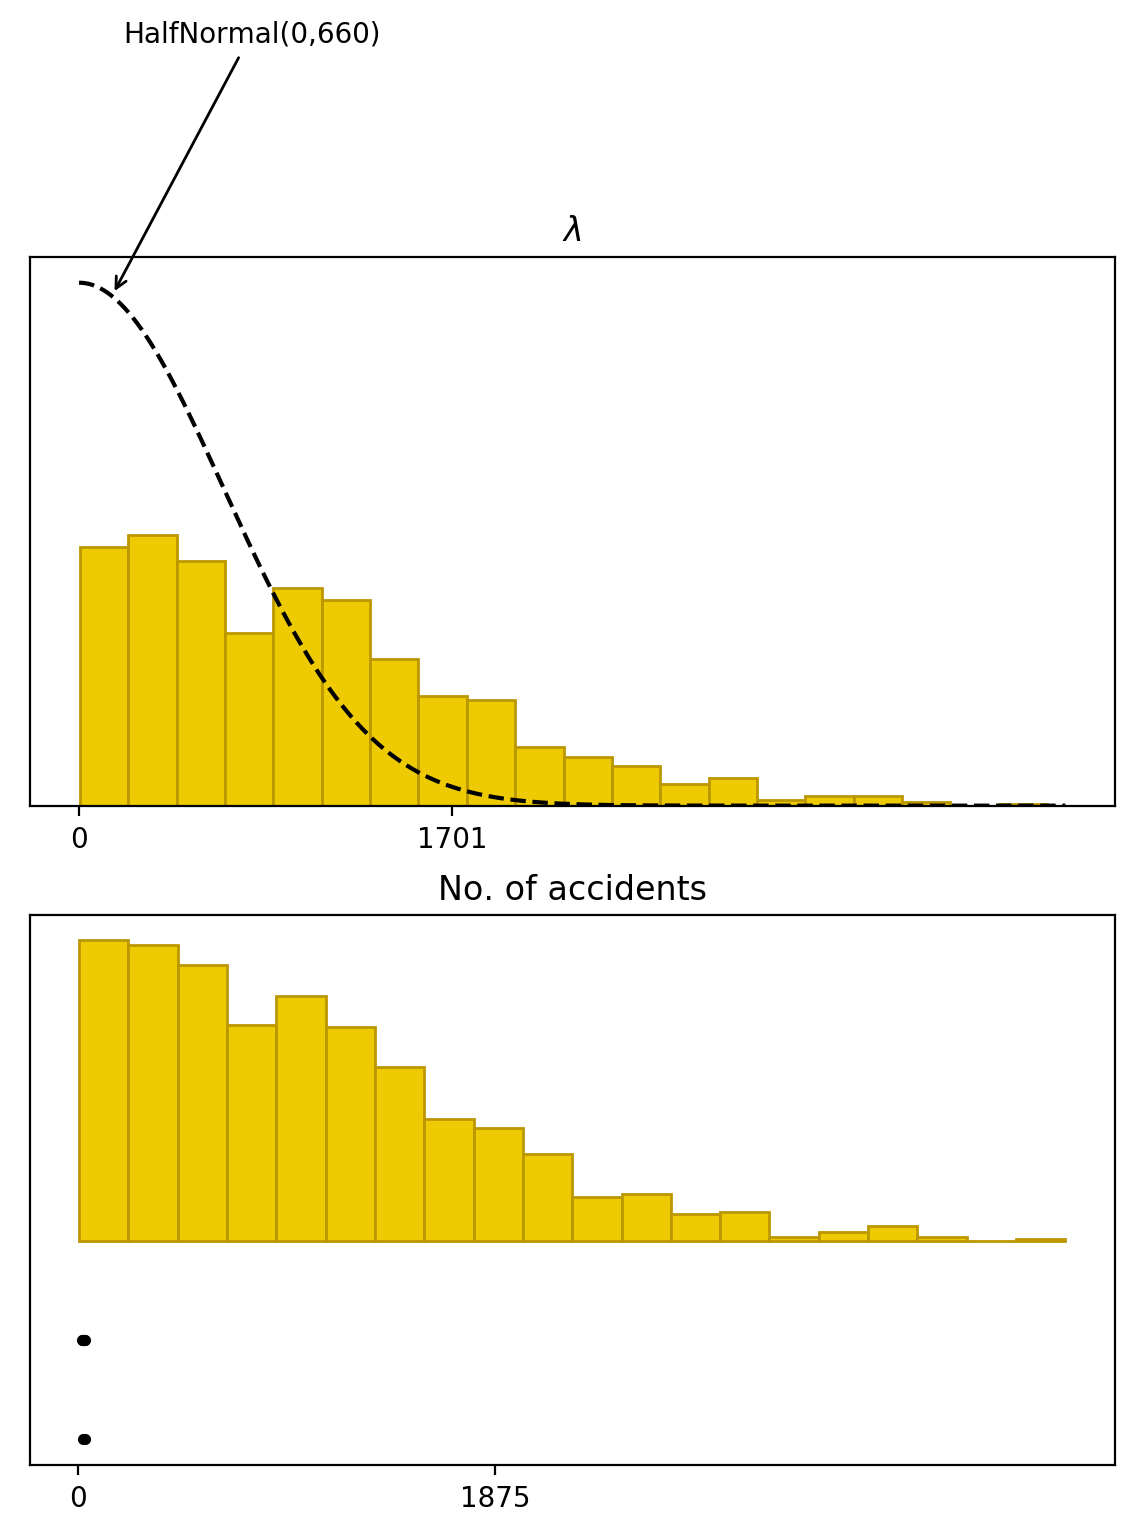

In [14]:
params=sim_uf.extract()
theta=params['lambda']
y_sim=params['y_sim']

fig, axes = plt.subplots(2, 1,figsize=(7, 8))
ax1=axes[0]
ax1.hist(theta,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,4500,2000)
ax1.set_xticks([0,lam_ub[0]])
ax1.set_yticks([])
ax1.set_title(r'$\lambda$')
ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(150,0,sigma)
ax1.annotate('HalfNormal(0,'+str(np.int(sigma))+')',xy=(150,arr_y_loc),xytext=(200,1.5*arr_y_loc),arrowprops={'arrowstyle':'->'})
ax2=axes[1]
ax2.hist(y_sim.flatten(),color=dark,edgecolor=dark_highlight,density=True,bins=20,zorder=1)
ax2.scatter(acc,0.0002*dta_cnt,color='black',marker='.',zorder=2)
ax2.set_xticks([0,1875])
ax2.set_yticks([])

ax2.set_title('No. of accidents')
plt.show()

Posterior predicitive checks and inference.

In [15]:
with open('airline_FA_hnorm_fit.stan', 'r') as file:
    print(file.read())

data {
  int M;
  int y[M];
}
parameters {
  real<lower=0>lambda;
}
model {
  lambda ~ normal(0,121);
  for (k in 1:M) {
    y[k] ~ poisson(lambda);
  }
}
generated quantities {
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(lambda);
  }
}

//source: https://github.com/KAIR-ISZ




In [16]:
model=stan_utility.compile_model('airline_FA_hnorm_fit.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_07461aac8cdfa7fc6a140cadce11b2d6 NOW.


In [17]:
data = dict(M = len(Airline_data),
            y = Airline_data['Passenger deaths'])
fit = model.sampling(data=data, seed=8052020)

params=fit.extract()
lam=params['lambda']
y_sim=params['y_sim']

In [18]:
mean_lam = np.mean(lam)
cinf_lam = az.hpd(lam,0.89)

hpd_width=cinf_lam[1]-cinf_lam[0]

C:\Users\Admin\Anaconda3\lib\site-packages\arviz\stats\stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


In [19]:
print('Mean lambda : {:4.2f}'.format(mean_lam))
print('89% confidence interval: [',*['{:4.2f}'.format(k) for k in cinf_lam],']')

Mean lambda : 688.80
89% confidence interval: [ 673.28 704.84 ]


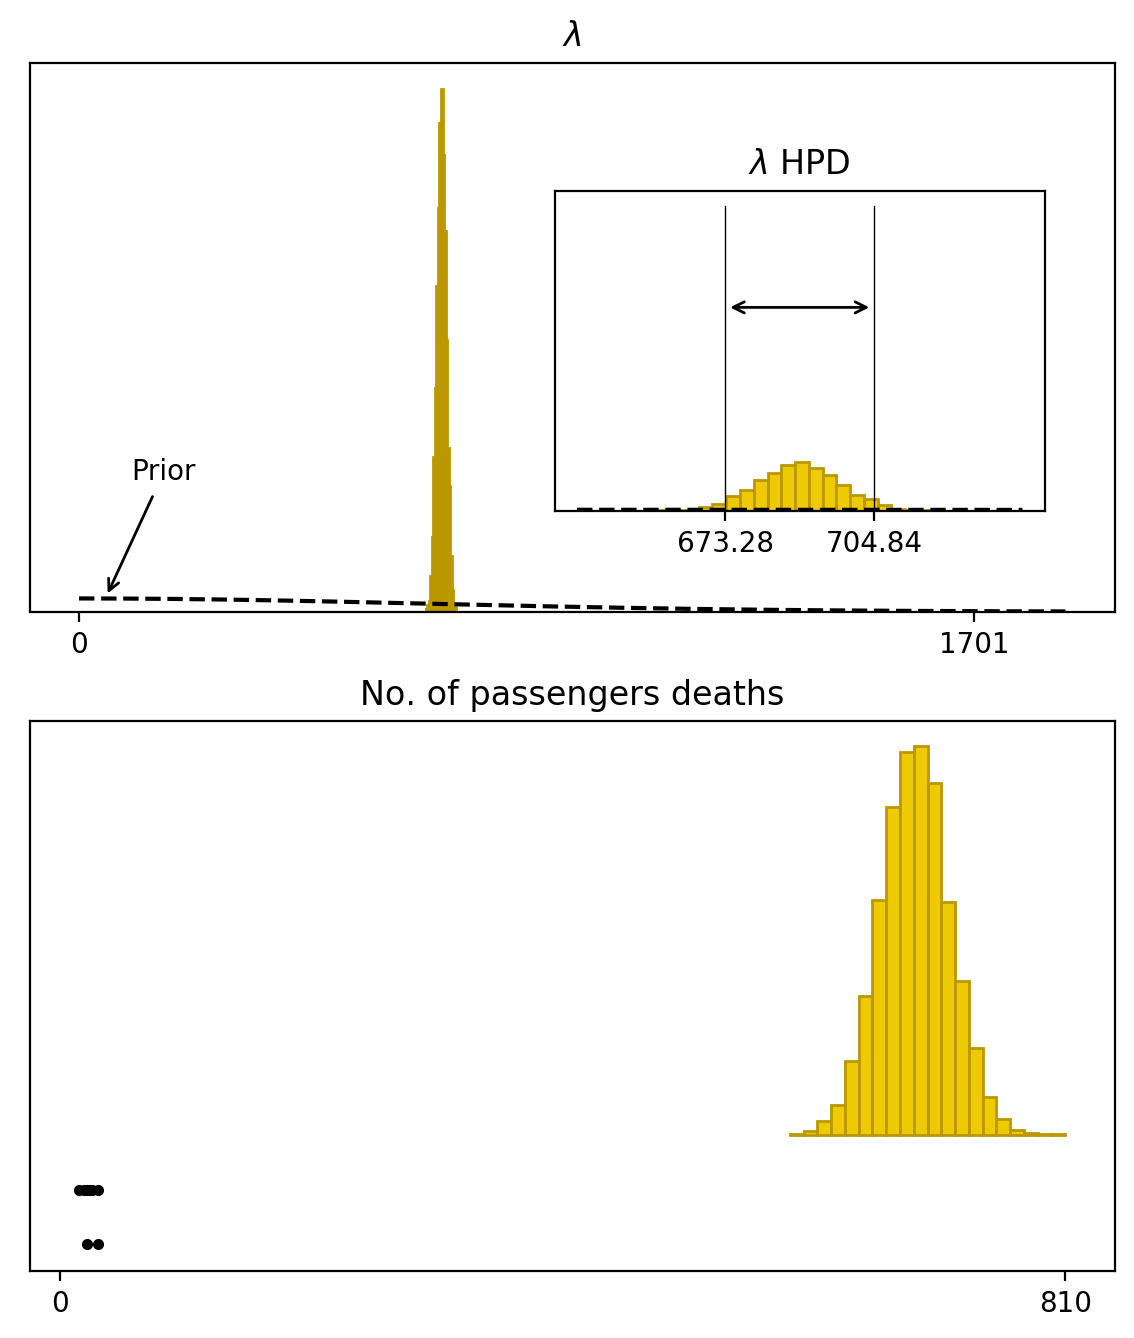

In [22]:
fig, axes = plt.subplots(2, 1,figsize=(7, 8))
ax1=axes[0]
ax1.hist(lam,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,1875,1000)

ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(50,0,sigma)
ax1.annotate('Prior',xy=(50,arr_y_loc),xytext=(100,10*arr_y_loc),arrowprops={'arrowstyle':'->'})
ax1.set_xticks([0,lam_ub[0]])

ax1.set_yticks([])
ax1.set_title(r'$\lambda$')

ax_sm=plt.axes([0.5,0.6,0.35,0.2])
x_sm=np.linspace(cinf_lam[0]-hpd_width,cinf_lam[1]+hpd_width,200)
ax_sm.hist(lam,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax_sm.plot(x_sm,2*stats.norm.pdf(x_sm,0,sigma),color='black',linestyle='--')
ax_sm.annotate(s='', xy=(cinf_lam[0]-.2,0.2), xytext=(cinf_lam[1]+.2,0.2), arrowprops=dict(arrowstyle='<->'))
ax_sm.plot([cinf_lam[0],cinf_lam[0]],[0,0.3],color='black',linestyle='-',linewidth=0.5)
ax_sm.plot([cinf_lam[1],cinf_lam[1]],[0,0.3],color='black',linestyle='-',linewidth=0.5)

ax_sm.set_xticks(np.round([cinf_lam[0],cinf_lam[1]],2))
ax_sm.set_yticks([])
ax_sm.set_title(r'$\lambda$ HPD')


ax2=axes[1]
ax2.hist(y_sim.flatten(),color=dark,edgecolor=dark_highlight,density=True,bins=20,zorder=1)
ax2.scatter(acc,0.002*dta_cnt,color='black',marker='.',zorder=2)
ax2.set_xticks([0,np.max(y_sim)])
ax2.set_yticks([])

ax2.set_title('No. of passengers deaths')
plt.show()

To predict number of deaths in 1986 I just need to use the prior predictive distribution of y_sim.

In [23]:
median_y_sim = np.median(y_sim.flatten())
cinf_y_sim = az.hpd(y_sim.flatten(),0.95)

print('Median of predicted deaths =',median_y_sim)
print('Confidence interval = [',*cinf_y_sim,']')

Median of predicted deaths = 688.0
Confidence interval = [ 636.0 739.0 ]


In 1986 there were 546 deaths, model predicted a bigger value.

2. I assume that the intensity is constant, but rate is a product of intensity and miles flown. I also assume that number of passengers deaths ($y_i$) has Poisson distribution: $$y_i\sim\mathrm{Poisson}(\lambda)$$

For this task I need to assume that 5 people dying every day has very low probability (5*365=1825). This time we assume that $\lambda=\theta\cdot\bar{n}$. This gives us condition $$\theta\cdot\bar{n}+3\sqrt{\theta\cdot\bar{n}}\approx1825$$

which means that probability is less than 1%.


In [24]:
mean_miles=np.mean(Airline_data['Miles flown [100 mln miles]'])
root_of_theta=np.polynomial.polynomial.polyroots([-365/mean_miles,3./np.sqrt(mean_miles),1.])
theta_ub=(root_of_theta[root_of_lam>0]**2)
print('theta upper bound','{:4.3f}'.format(theta_ub[0]))

theta upper bound 0.055


In [25]:
data=dict(y_guess=np.array([np.log(0.01)]),theta=np.array(theta_ub))
tuned2 = tuning2.sampling(data=data,
                          seed=1052020,
                          algorithm="Fixed_param",
                          iter=1, 
                          warmup=0,
                          chains=1)
sigma = (tuned2.extract()['sigma'][0])
print('sigma =','{:4.3f}'.format(sigma))

sigma = 0.021


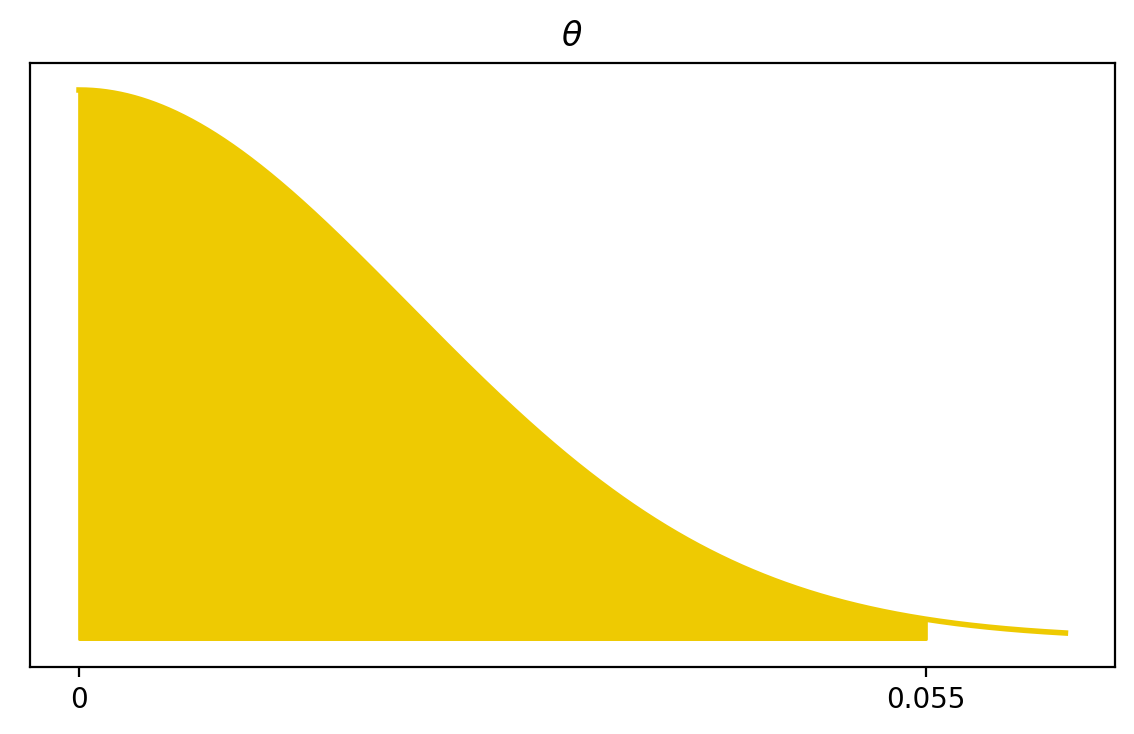

In [27]:
fig, ax2 = plt.subplots(1, 1,figsize=(7, 4))
x2=np.linspace(0,3*sigma,1000)
x4=np.linspace(0,theta_ub[0],1000)
ax2.plot(x2,2*stats.norm.pdf(x2,scale=sigma),color=dark,linewidth=2)
ax2.fill_between(x4,2*stats.norm.pdf(x4,scale=sigma),0,color=dark)
ax2.set_yticks([])
ax2.set_xticks([0,theta_ub[0]])
ax2.set_xticklabels([0,0.055])
ax2.set_title(r'$\theta$')
plt.show()

I will use stan to simulate possible outputs and parameteres based only on prior information.

In [28]:
with open('airline_FA_miles_hnorm_ppc.stan', 'r') as file:
    print(file.read())

data {
  int M;
  vector[M] miles;
}
generated quantities {
  real theta=fabs(normal_rng(0,0.236));
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(theta*miles[k]);
  }
}

//source: https://github.com/KAIR-ISZ




In [29]:
model_prior=stan_utility.compile_model('airline_FA_miles_hnorm_ppc.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1eb3ae97d68ac32588bc07659afcca15 NOW.


In [30]:
R=1000
data_prior=dict(M=len(Airline_data),miles=Airline_data['Miles flown [100 mln miles]'].to_numpy())
sim_uf=model_prior.sampling(data=data_prior,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                     seed=29042020)

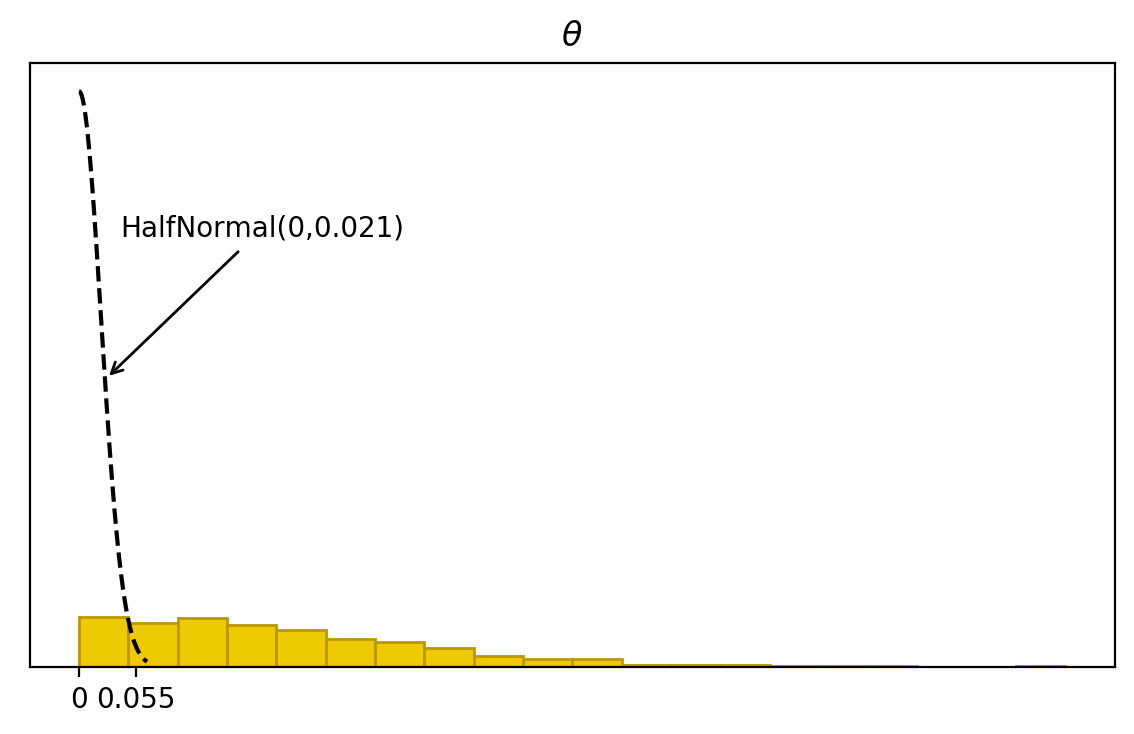

In [31]:
params=sim_uf.extract()
theta=params['theta']

fig, axes = plt.subplots(1, 1,figsize=(7, 4))
ax1=axes
ax1.hist(theta,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,1.2*theta_ub[0],2000)
ax1.set_xticks([0,theta_ub[0]])
ax1.set_xticklabels([0,np.round(theta_ub[0],3)])
ax1.set_yticks([])
ax1.set_title(r'$\theta$')
ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(0.025,0,sigma)
ax1.annotate('HalfNormal(0,'+'{:4.3f}'.format(sigma)+')',xy=(0.025,arr_y_loc),xytext=(0.04,1.5*arr_y_loc),arrowprops={'arrowstyle':'->'})
plt.show()

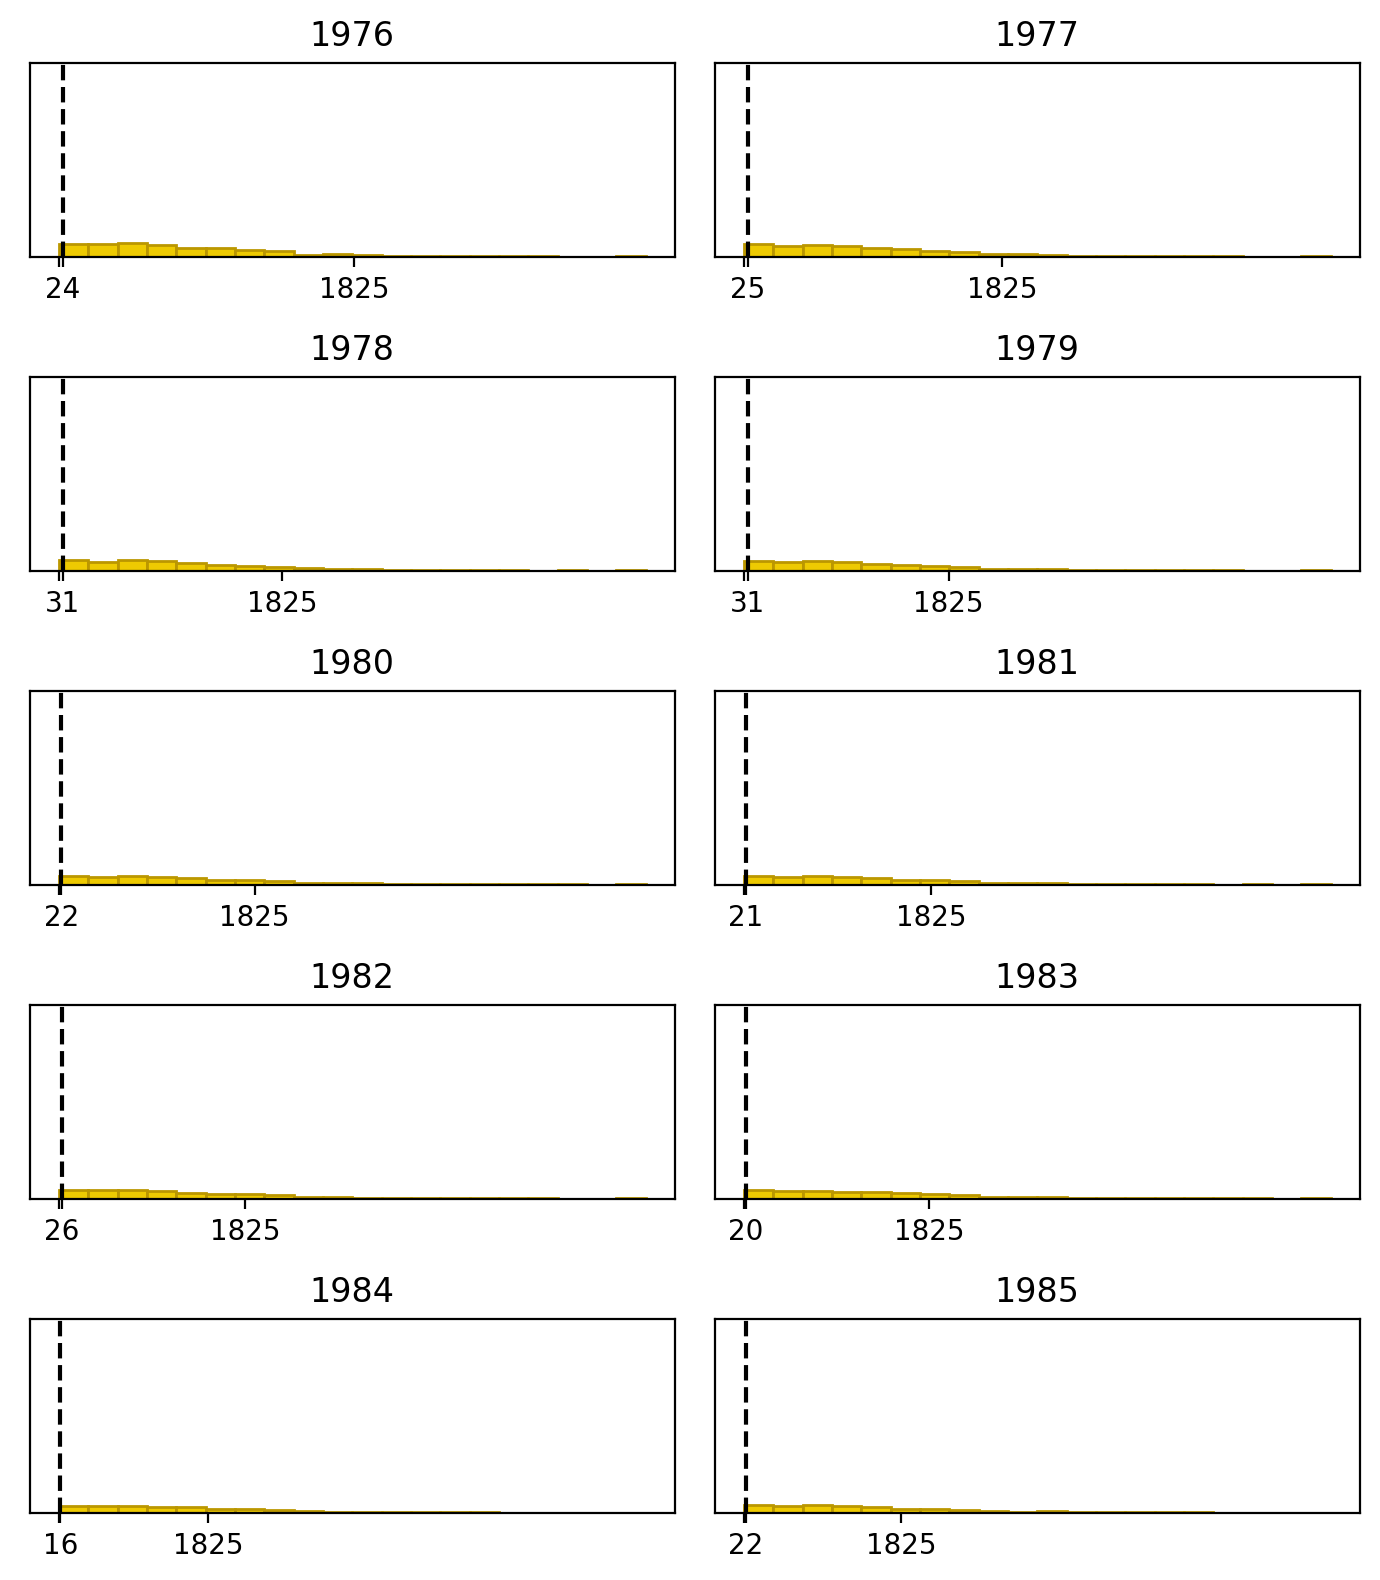

In [33]:
y_sim=params['y_sim']
fig, axes = plt.subplots(5, 2, figsize=(7, 8), sharey=True,squeeze=False)
axes_flat=axes.flatten()
for k in range(len(axes_flat)):
    ax = axes_flat[k]
    ax.hist(y_sim[:,k],bins=20,color=dark,edgecolor=dark_highlight,density=True)
    ax.set_title(Airline_data.index[k])
    tv=Airline_data['Fatal accidents'].iloc[k]
    ax.plot([tv,tv],[0,0.02],linestyle='--',color='black')
    ax.set_yticks([])
    ax.set_xticks([0,tv,1825])
    ax.set_xticklabels(['',tv,1825])
    ax.set_ylim([0,0.012])

fig.tight_layout()

plt.show()

Posterior predicitive checks and inference.

In [34]:
with open('airline_FA_miles_hnorm_fit.stan', 'r') as file:
    print(file.read())

data {
  int M;//number of years analyzed
  vector[M] miles; //number of miles flown each year
  int y[M];//number of fatal accidents
}
parameters {
  real<lower=0>theta;
}
model {
  theta ~ normal(0,0.021);
  for (k in 1:M) {
    y[k] ~ poisson(miles[k]*theta);
  }
}
generated quantities {
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(miles[k]*theta);
  }
}
//source: https://github.com/KAIR-ISZ


In [35]:
model_miles=stan_utility.compile_model('airline_FA_miles_hnorm_fit.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4aa5461f24e9569e7e2e689b3d1b1062 NOW.


In [36]:
data = dict(M = len(Airline_data),
            miles = Airline_data['Miles flown [100 mln miles]'],
            y = Airline_data['Passenger deaths'])
fit = model_miles.sampling(data=data, seed=8052020)

params_miles=fit.extract()
theta=params_miles['theta']
y_sim=params_miles['y_sim']

In [37]:
mean_theta = np.mean(theta)
cinf_theta = az.hpd(theta,0.89)
hpd_width=cinf_theta[1]-cinf_theta[0]

In [38]:
print('Mean theta : {:5.4f}'.format(mean_theta))
print('89% confidence interval: [',*['{:5.4f}'.format(k) for k in cinf_theta],']')

Mean theta : 0.1205
89% confidence interval: [ 0.1178 0.1230 ]


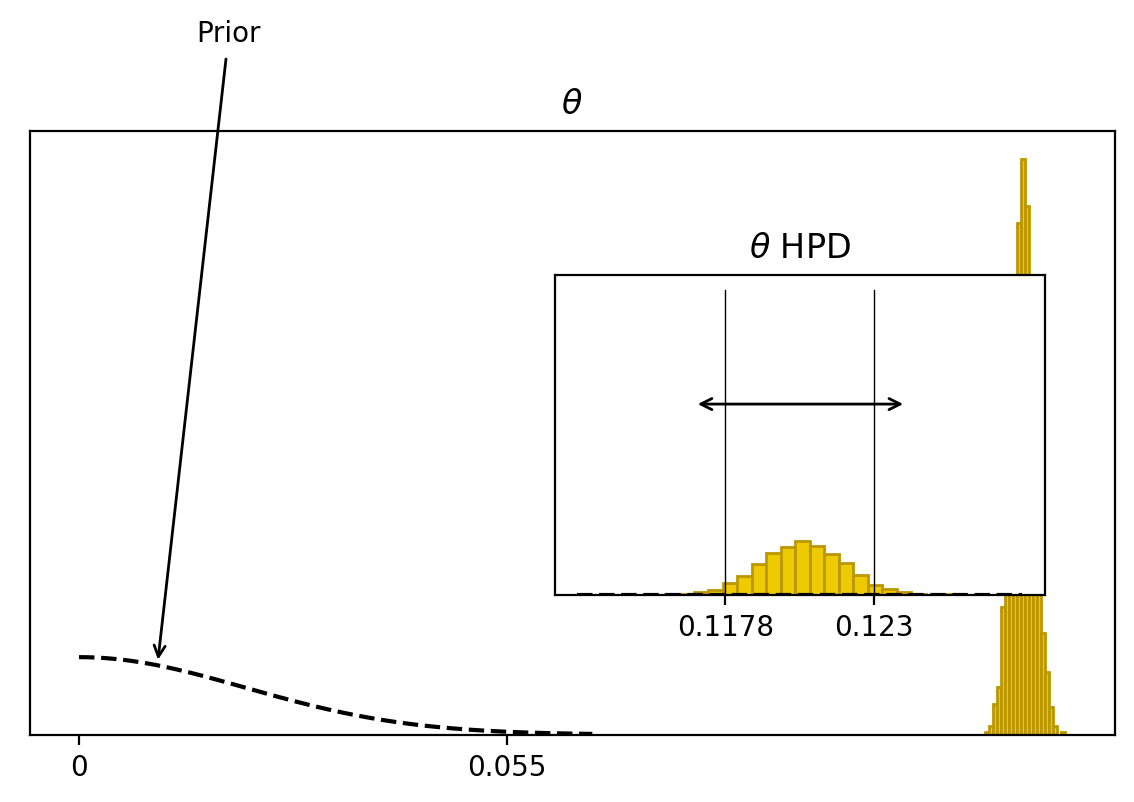

In [42]:
fig, axes = plt.subplots(1, 1,figsize=(7, 4))
ax1=axes
ax1.hist(theta,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,1.2*theta_ub[0],10000)
ax1.set_xticks([0,theta_ub[0]])
ax1.set_xticklabels([0,np.round(theta_ub[0],3)])
ax1.set_yticks([])
ax1.set_title(r'$\theta$')
ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(0.01,0,sigma)
ax1.annotate('Prior',xy=(0.01,arr_y_loc),xytext=(0.015,10*arr_y_loc),arrowprops={'arrowstyle':'->'})

ax_sm=plt.axes([0.5,0.3,0.35,0.4])
x_sm=np.linspace(cinf_theta[0]-hpd_width,cinf_theta[1]+hpd_width,1000)
ax_sm.hist(theta,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax_sm.plot(x_sm,2*stats.norm.pdf(x_sm,0,sigma),color='black',linestyle='--')
ax_sm.annotate(s='', xy=(0.99*cinf_theta[0],1000), xytext=(1.01*cinf_theta[1],1000), arrowprops=dict(arrowstyle='<->'))
ax_sm.plot([cinf_theta[0],cinf_theta[0]],[0,1600],color='black',linestyle='-',linewidth=0.5)
ax_sm.plot([cinf_theta[1],cinf_theta[1]],[0,1600],color='black',linestyle='-',linewidth=0.5)

ax_sm.set_xticks(([cinf_theta[0],cinf_theta[1]]))
ax_sm.set_xticklabels(np.round([cinf_theta[0],cinf_theta[1]],4))

ax_sm.set_yticks([])
ax_sm.set_title(r'$\theta$ HPD')

plt.show()

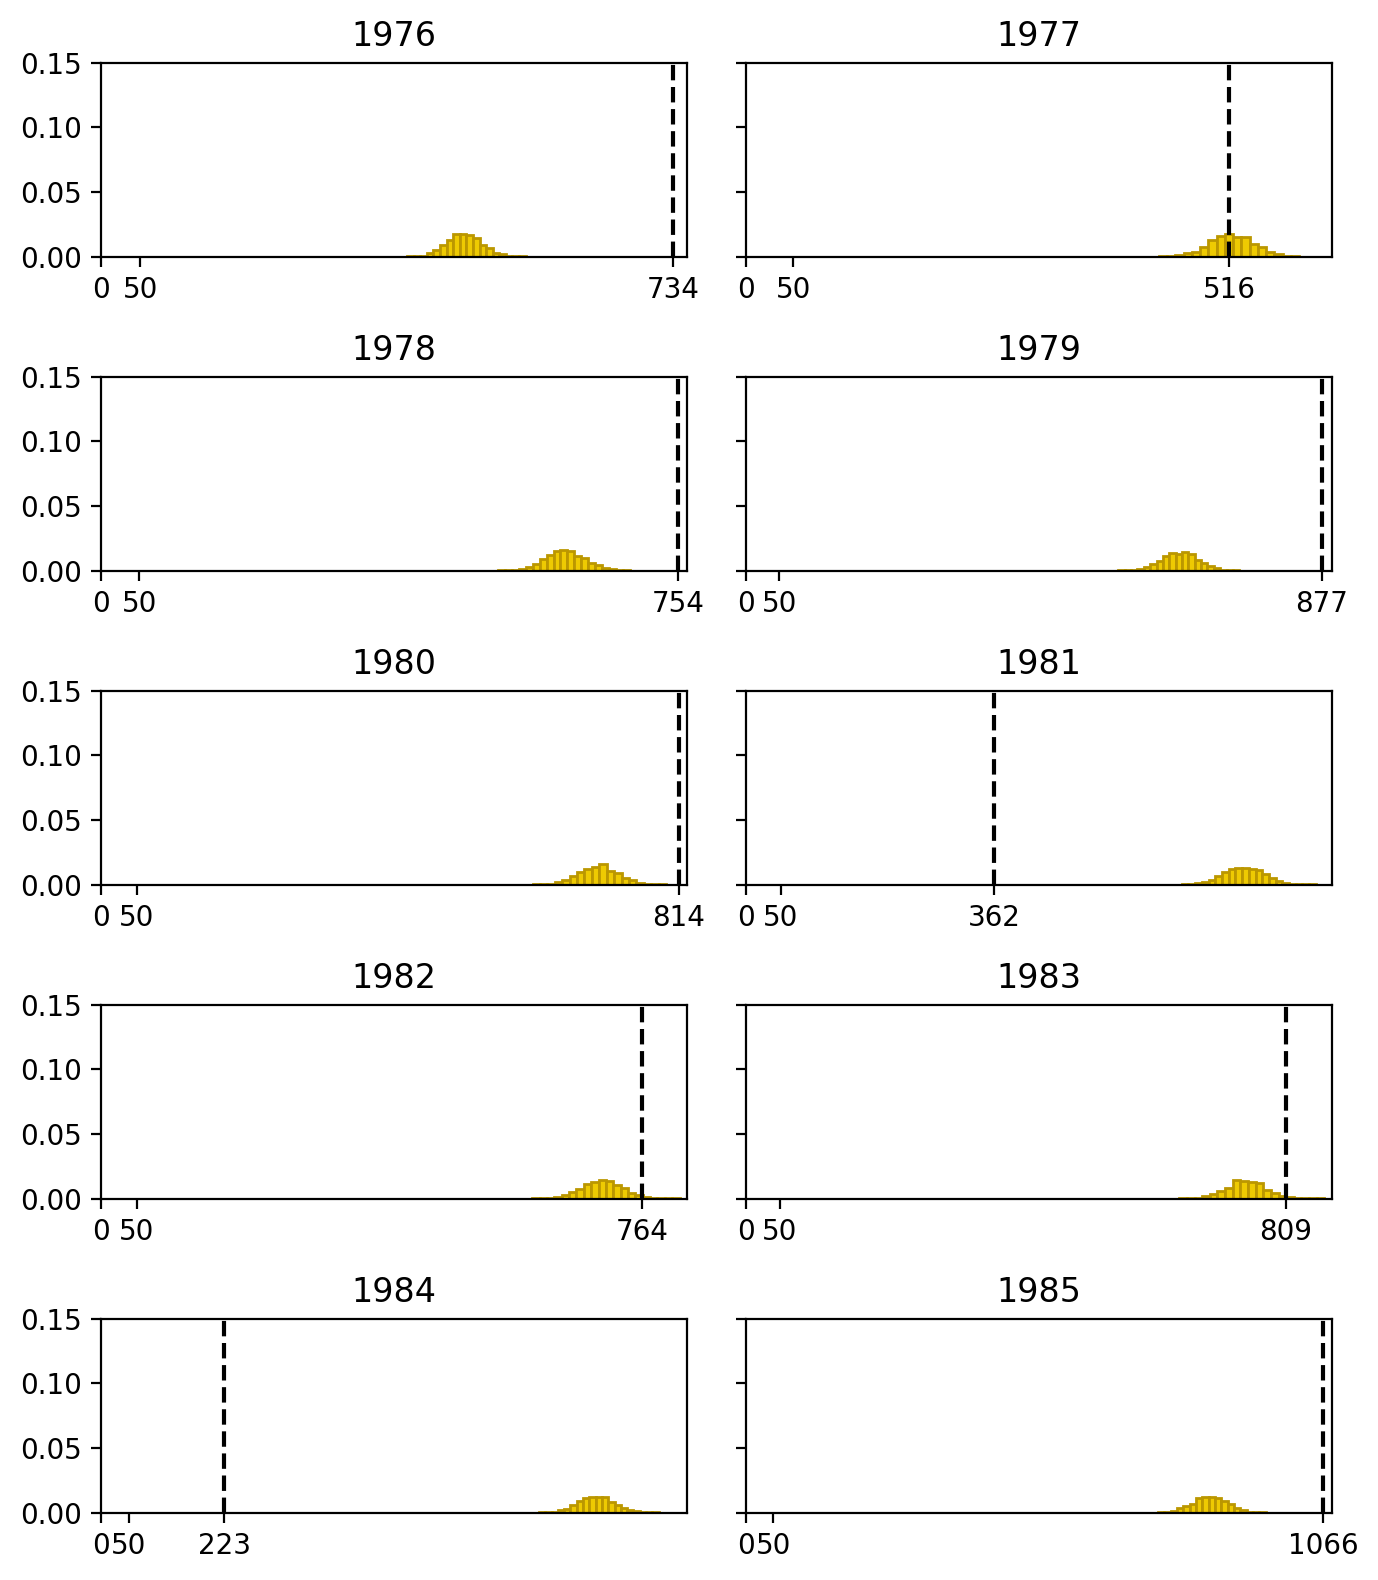

In [44]:
y_sim=params_miles['y_sim']
fig, axes = plt.subplots(5, 2, figsize=(7, 8), sharey=True,squeeze=False)
axes_flat=axes.flatten()
for k in range(len(axes_flat)):
    ax = axes_flat[k]
    ax.hist(y_sim[:,k],bins=20,color=dark,edgecolor=dark_highlight,density=True)
    ax.set_title(Airline_data.index[k])
    tv=Airline_data['Passenger deaths'].iloc[k]
    ax.plot([tv,tv],[0,0.15],linestyle='--',color='black')
    #ax.set_yticks([])
    ax.set_xticks([0,tv,50])
    ax.set_xticklabels([0,tv,50])
    ax.set_ylim([0,0.15])

fig.tight_layout()

plt.show()

I will predict number of deaths in 1986.

In [45]:
miles1986=546/0.06
print(np.round(miles1986))

9100.0


In [46]:
with open('airline_FA_miles_1986.stan', 'r') as file:
    print(file.read())

data {
  int M;//number of years analyzed
  vector[M] miles; //number of miles flown each year
  int y[M];//number of fatal accidents
}
parameters {
  real<lower=0>theta;
}
model {
  theta ~ normal(0,0.021);
  for (k in 1:M) {
    y[k] ~ poisson(miles[k]*theta);
  }
}
generated quantities {
  int y_1986 = poisson_rng(9100*theta);
}
//source: https://github.com/KAIR-ISZ


In [47]:
model1986=stan_utility.compile_model('airline_FA_miles_1986.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d8ace9dab3b76759af4adc1ba745bcd6 NOW.


In [48]:
data = dict(M = len(Airline_data),
            miles = Airline_data['Miles flown [100 mln miles]'],
            y = Airline_data['Passenger deaths'])
fit1986 = model1986.sampling(data=data, seed=8052020)

y_1986=fit1986.extract()['y_1986']

In [49]:
median_y_1986 = np.median(y_1986)
cinf_y_1986 = az.hpd(y_1986,0.89)

print('Median of predicted accidents =',median_y_1986)
print('Confidence interval = [',*cinf_y_1986,']')

Median of predicted accidents = 1098.0
Confidence interval = [ 1029.0 1159.0 ]


Result is much worse (almostt twice) then the one i received in task one. It happens even though is second task I have analysed more data. 